In [1]:
import numpy as np
import torch
import modules.evaluate as evaluate
import matplotlib
import matplotlib.pyplot as plt


modelLoads= ["AA", "AB", "BA", "BB", "infer2018"]
weightModels= ["degree", "gravity", "identical"]
randomGraphs= ["ER", "BA", "WS", "RGG"]
seeds= [10, 11, 12, 13, 14]
strains= [1, 2, 3, 4]
denses= [0, -1, -2, -3, -4]
nodes= [50, 100, 200, 400]
intenses= [0, 1, 2, -1]

identicalfs= [2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1]# except 1e-2

commands1=set()
linuxThread= 3

In [2]:
def continious_to_sparcity(my_array, top= 400):
    # Flatten the array to a 1D array
    flat_array = my_array.flatten()

    # Sort the flattened array in descending order
    sorted_indices = np.argsort(flat_array)[::-1]

    # Set the top 400 elements to 1 and the rest to 0
    flat_array[sorted_indices[:top]] = 1
    flat_array[sorted_indices[top:]] = 0

    # Reshape the modified 1D array back to the original shape
    result_array = flat_array.reshape(my_array.shape)
    return result_array

def continious_to_sparcity_cols(my_matrix, topRow= 8):

    result_matrix = np.zeros_like(my_matrix)
    indices = np.argsort(my_matrix, axis=1)[:, -topRow:]  # Get indices of top 8 elements in each row
    row_indices = np.arange(my_matrix.shape[0])[:, None]  # Row indices to broadcast
    result_matrix[row_indices, indices] = 1
    
    return result_matrix

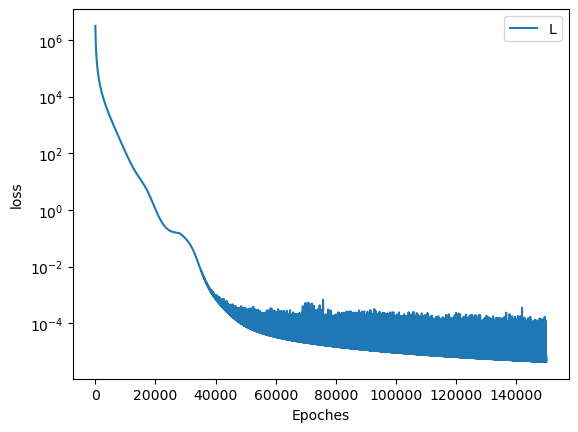

In [44]:
identicalf= 0.01

node= 100

strain= 4

#AA_RGG_identical_12_2_-1_0_100_10.0_150000
#AA_ER_identical_13_4_-1_0_100_10.0_150000
#AA_WS_identical_11_1_-1_0_100_10.0_150000
#AA_WS_identical_11_4_-1_0_100_10.0_150000

fileName= f"results/AA/AA_RGG_identical_{13}_{strain}_-1_0_100_{identicalf*1000}_150000.npz"
IMatrix= torch.eye(node, device= "cpu")
npzfile = np.load(fileName)
loss= npzfile['loss']
taus= npzfile["taus"]

plt.plot(loss)
plt.yscale("log")
plt.xlabel("Epoches")
plt.ylabel("loss")
plt.legend("Loss")



In [55]:

identicalf= 0.01
node= 50
strain= 4
#Performance on different models

for randomGraph in randomGraphs:
    cosinesList= []
    spectralsList= []
    edgesList= []
    jaccardsList= []
    for modelLoad in modelLoads:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        minus= 0
        for seed in seeds:
            try:
                if modelLoad=="AA":
                    fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{strain}_0_8_50_{identicalf*1000}_140000.npz"
                else:
                    fileName= f"results/{modelLoad}/{modelLoad}_{randomGraph}_identical_{seed}_{strain}_0_100000.npz"
                IMatrix= torch.eye(node, device= "cpu")
                npzfile = np.load(fileName)
            except:
                #print(fileName)
                minus+=1
                continue
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosines+= evaluate.cosine_similarity(Aw, PreA)
            spectrals+= evaluate.spectral_analysis(Aw, PreA)
            edges+= evaluate.edge_correctness(Aws, PreAs)
            jaccards+= evaluate.jaccard_index(Aws, PreAs)
        cosines/= len(seeds)-minus
        spectrals/= len(seeds)-minus
        edges/= len(seeds)-minus
        jaccards/= len(seeds)-minus
        cosinesList.append(f"{cosines:.2f}")
        spectralsList.append(f"{spectrals:.2f}")
        edgesList.append(f"{edges:.2f}")
        jaccardsList.append(f"{jaccards:.2f}")
        #print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
    print("\t".join(cosinesList)+"\t"+"\t".join(spectralsList)+"\t"+"\t".join(edgesList)+"\t"+"\t".join(jaccardsList))
    #print()

0.74	0.55	0.33	0.56	0.57	0.51	0.60	0.49	0.46	0.58	0.69	0.38	0.38	0.56	0.57	0.52	0.23	0.23	0.39	0.40
0.77	0.51	0.33	0.53	0.55	0.49	0.63	0.54	0.49	0.53	0.74	0.35	0.37	0.57	0.58	0.59	0.21	0.23	0.40	0.41
0.77	0.56	0.34	0.60	0.61	0.70	0.59	0.67	0.68	0.64	0.75	0.39	0.39	0.62	0.61	0.60	0.25	0.24	0.45	0.44
0.93	0.64	0.47	0.58	0.60	0.93	0.74	0.79	0.85	0.82	0.97	0.52	0.52	0.74	0.75	0.95	0.35	0.35	0.59	0.60


In [5]:
#AA_WS_identical_11_4_-1_0_100_10.0_150000

identicalf= 0.01
node= 100
#Performance on different strains new

for randomGraph in randomGraphs:
    cosinesList= []
    spectralsList= []
    edgesList= []
    jaccardsList= []
    for strain in strains:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        for seed in seeds:
            try:
                fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{strain}_-1_0_{node}_{identicalf*1000}_150000.npz"
                IMatrix= torch.eye(node, device= "cpu")
                npzfile = np.load(fileName)
            except:
                print(fileName)
                continue
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosines+= evaluate.cosine_similarity(Aw, PreA)
            spectrals+= evaluate.spectral_analysis(Aw, PreA)
            edges+= evaluate.recall(Aws, PreAs)
            jaccards+= evaluate.jaccard_index(Aws, PreAs)
        cosines/= len(seeds)
        spectrals/= len(seeds)
        edges/= len(seeds)
        jaccards/= len(seeds)
        cosinesList.append(f"{cosines:.2f}")
        spectralsList.append(f"{spectrals:.2f}")
        edgesList.append(f"{edges:.2f}")
        jaccardsList.append(f"{jaccards:.2f}")
        #print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
    print("\t".join(cosinesList)+"\t"+"\t".join(spectralsList)+"\t"+"\t".join(edgesList)+"\t"+"\t".join(jaccardsList))
    #print()

0.31	0.50	0.58	0.65	0.33	0.28	0.26	0.20	0.31	0.45	0.52	0.60	0.19	0.29	0.36	0.43
0.43	0.60	0.65	0.74	0.37	0.43	0.34	0.21	0.44	0.56	0.62	0.72	0.28	0.39	0.45	0.56
0.24	0.70	0.82	0.89	0.34	0.62	0.75	0.78	0.33	0.67	0.82	0.91	0.20	0.50	0.70	0.83
0.44	0.84	0.92	0.96	0.55	0.78	0.84	0.83	0.49	0.83	0.92	0.97	0.34	0.72	0.86	0.94


In [7]:
IMatrix= torch.eye(100, device= "cpu")
identicalf= 0.01

cosinesNp= []
spectralsNp= []
edgesNp= []
jaccardsNp= []
#Performance on different dense

for randomGraph in randomGraphs:
    cosinesList= []
    spectralsList= []
    edgesList= []
    jaccardsList= []
    for dense in denses:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        for seed in seeds:
            try:
                fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{4}_-1_{dense}_{100}_{identicalf*1000}_150000.npz"
                npzfile = np.load(fileName)
                # Access the arrays in the NPZ file
                Awnp= npzfile['A']
                PreAnp= npzfile['Apre']
                Aw = torch.tensor(Awnp)
                PreA = torch.tensor(PreAnp)
                links= int(torch.sum(Aw)/identicalf)  
                Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
                PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
                cosines+= evaluate.cosine_similarity(Aw, PreA)
                spectrals+= evaluate.spectral_analysis(Aw, PreA)
                edges+= evaluate.recall(Aws, PreAs)
                jaccards+= evaluate.jaccard_index(Aws, PreAs)
            except:
                print(fileName)
                pass
        cosines/= len(seeds)
        spectrals/= len(seeds)
        edges/= len(seeds)
        jaccards/= len(seeds)
        cosinesList.append(f"{cosines:.2f}")
        spectralsList.append(f"{spectrals:.2f}")
        edgesList.append(f"{edges:.2f}")
        jaccardsList.append(f"{jaccards:.2f}")
        #print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
    cosinesNp.append(cosinesList)
    spectralsNp.append(spectralsList)
    edgesNp.append(edgesList)
    jaccardsNp.append(jaccardsList)
        #print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
    print("\t".join(cosinesList)+"\t"+"\t".join(spectralsList)+"\t"+"\t".join(edgesList)+"\t"+"\t".join(jaccardsList))
    #print()
cosinesNp= np.array(cosinesNp).astype(float)
spectralsNp= np.array(spectralsNp).astype(float)
edgesNp= np.array(edgesNp).astype(float)
jaccardsNp= np.array(jaccardsNp).astype(float)


0.65	0.62	0.60	0.61	0.61	0.20	0.22	0.32	0.23	0.41	0.60	0.57	0.53	0.53	0.53	0.43	0.40	0.36	0.36	0.36
0.74	0.68	0.69	0.68	0.67	0.21	0.38	0.43	0.49	0.47	0.72	0.64	0.65	0.63	0.61	0.56	0.47	0.48	0.46	0.44
0.89	0.88	0.86	0.84	0.83	0.78	0.75	0.83	0.82	0.83	0.91	0.89	0.87	0.85	0.84	0.83	0.81	0.78	0.74	0.72
0.96	0.96	0.96	0.95	0.94	0.83	0.83	0.84	0.88	0.90	0.97	0.98	0.98	0.98	0.97	0.94	0.96	0.96	0.96	0.95


In [10]:
print(denses)
print(cosinesNp.shape)

-4
(4, 5)


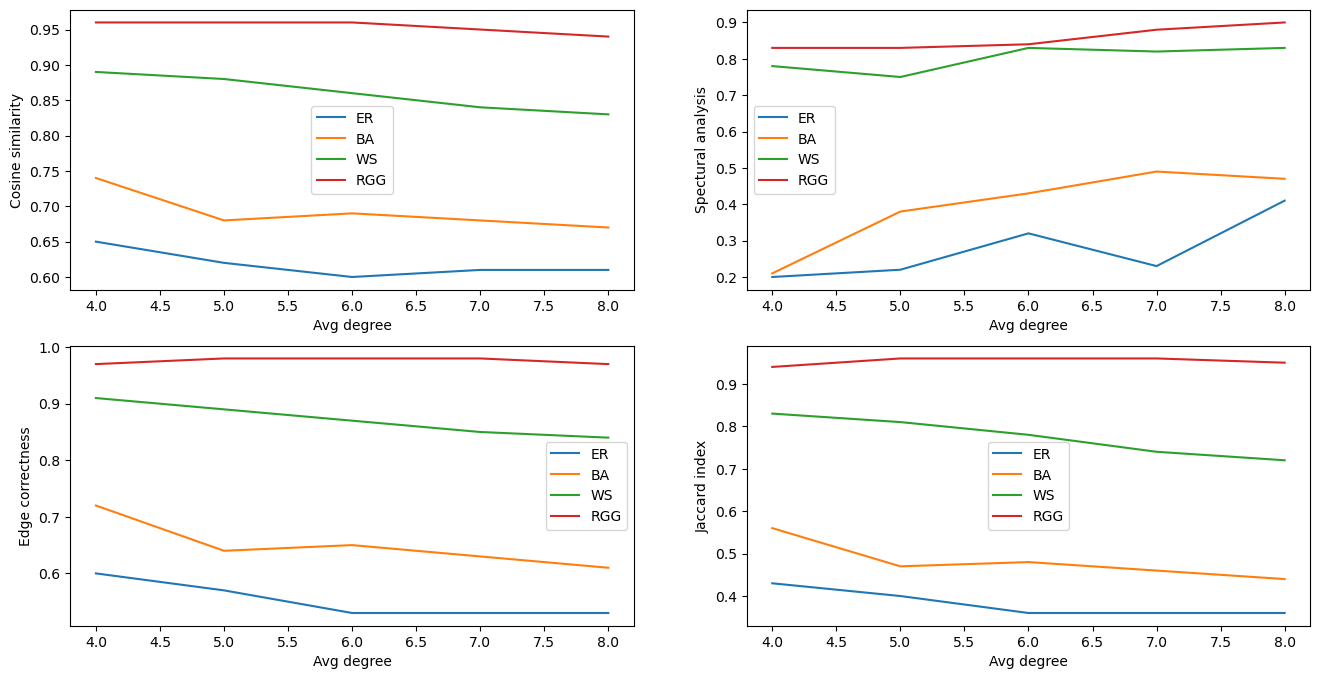

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
import math 
axs[0, 0].plot(int(math.log(100))-np.array(denses) ,cosinesNp.T)
axs[0, 0].set_ylabel('Cosine similarity')
axs[0, 0].set_xlabel("Avg degree")
axs[0, 0].legend(["ER", "BA", "WS", "RGG"])


axs[0, 1].plot(int(math.log(100))-np.array(denses) ,spectralsNp.T)
axs[0, 1].set_ylabel('Spectural analysis')
axs[0, 1].set_xlabel("Avg degree")
axs[0, 1].legend(["ER", "BA", "WS", "RGG"])

axs[1, 0].plot(int(math.log(100))-np.array(denses) ,edgesNp.T)
axs[1, 0].set_ylabel('Edge correctness')
axs[1, 0].set_xlabel("Avg degree")
axs[1, 0].legend(["ER", "BA", "WS", "RGG"])

axs[1, 1].plot(int(math.log(100))-np.array(denses) ,jaccardsNp.T)
axs[1, 1].set_ylabel('Jaccard index')
axs[1, 1].set_xlabel("Avg degree")
axs[1, 1].legend(["ER", "BA", "WS", "RGG"])



In [4]:

identicalf= 0.01
#Performance on different node number

for randomGraph in randomGraphs:
    cosinesList= []
    spectralsList= []
    edgesList= []
    jaccardsList= []
    for node in nodes:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        for seed in seeds:
            fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{4}_-1_0_{node}_{0.01*1000}_150000.npz"
            IMatrix= torch.eye(node, device= "cpu")
            npzfile = np.load(fileName)
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosines+= evaluate.cosine_similarity(Aw, PreA)
            spectrals+= evaluate.spectral_analysis(Aw, PreA)
            edges+= evaluate.recall(Aws, PreAs)
            jaccards+= evaluate.jaccard_index(Aws, PreAs)
        cosines/= len(seeds)
        spectrals/= len(seeds)
        edges/= len(seeds)
        jaccards/= len(seeds)
        cosinesList.append(f"{cosines:.2f}")
        spectralsList.append(f"{spectrals:.2f}")
        edgesList.append(f"{edges:.2f}")
        jaccardsList.append(f"{jaccards:.2f}")
        #print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
    print("\t".join(cosinesList)+"\t"+"\t".join(spectralsList)+"\t"+"\t".join(edgesList)+"\t"+"\t".join(jaccardsList))
    #print()


0.87	0.65	0.50	0.38	0.18	0.20	0.12	0.21	0.86	0.60	0.45	0.34	0.76	0.43	0.29	0.20
0.88	0.74	0.58	0.50	0.45	0.21	0.12	0.22	0.89	0.72	0.55	0.47	0.80	0.56	0.38	0.31
0.97	0.89	0.79	0.74	0.76	0.78	0.76	0.68	0.98	0.91	0.79	0.73	0.97	0.83	0.65	0.58
0.98	0.96	0.94	0.92	0.90	0.83	0.77	0.78	0.99	0.97	0.95	0.93	0.98	0.94	0.92	0.88


In [6]:

identicalf= 0.01
node= 100
#Performance on different intense

for randomGraph in randomGraphs:
    cosinesList= []
    spectralsList= []
    edgesList= []
    jaccardsList= []
    for intense in intenses:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        for seed in seeds:
            fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{4}_{intense}_0_{node}_{0.01*1000}_150000.npz"
            IMatrix= torch.eye(node, device= "cpu")
            npzfile = np.load(fileName)
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosines+= evaluate.cosine_similarity(Aw, PreA)
            spectrals+= evaluate.spectral_analysis(Aw, PreA)
            edges+= evaluate.recall(Aws, PreAs)
            jaccards+= evaluate.jaccard_index(Aws, PreAs)
        cosines/= len(seeds)
        spectrals/= len(seeds)
        edges/= len(seeds)
        jaccards/= len(seeds)
        cosinesList.append(f"{cosines:.2f}")
        spectralsList.append(f"{spectrals:.2f}")
        edgesList.append(f"{edges:.2f}")
        jaccardsList.append(f"{jaccards:.2f}")
        #print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
    print("\t".join(cosinesList)+"\t"+"\t".join(spectralsList)+"\t"+"\t".join(edgesList)+"\t"+"\t".join(jaccardsList))
    #print()


0.66	0.66	0.64	0.65	0.25	0.19	0.21	0.20	0.62	0.62	0.60	0.60	0.45	0.45	0.43	0.43
0.75	0.75	0.74	0.74	0.30	0.37	0.28	0.21	0.73	0.73	0.71	0.72	0.58	0.58	0.56	0.56
0.89	0.90	0.90	0.89	0.72	0.73	0.77	0.78	0.90	0.92	0.92	0.91	0.83	0.84	0.84	0.83
0.97	0.97	0.95	0.96	0.86	0.82	0.82	0.83	0.98	0.98	0.96	0.97	0.96	0.97	0.92	0.94


In [9]:
#AA_WS_identical_11_4_-1_0_100_10.0_150000
cosinesNp= []
spectralsNp= []
edgesNp= []
jaccardsNp= []
identicalf= 0.01
node= 100
#Performance on different identicalf new

for randomGraph in randomGraphs:
    cosinesList= []
    spectralsList= []
    edgesList= []
    jaccardsList= []
    for identicalf in identicalfs:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        for seed in seeds:
            fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{4}_-1_0_{node}_{identicalf*1000}_150000.npz"
            IMatrix= torch.eye(node, device= "cpu")
            npzfile = np.load(fileName)
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosines+= evaluate.cosine_similarity(Aw, PreA)
            spectrals+= evaluate.spectral_analysis(Aw, PreA)
            edges+= evaluate.recall(Aws, PreAs)
            jaccards+= evaluate.jaccard_index(Aws, PreAs)
        cosines/= len(seeds)
        spectrals/= len(seeds)
        edges/= len(seeds)
        jaccards/= len(seeds)
        cosinesList.append(f"{cosines:.2f}")
        spectralsList.append(f"{spectrals:.2f}")
        edgesList.append(f"{edges:.2f}")
        jaccardsList.append(f"{jaccards:.2f}")
    cosinesNp.append(cosinesList)
    spectralsNp.append(spectralsList)
    edgesNp.append(edgesList)
    jaccardsNp.append(jaccardsList)
        #print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
    print("\t".join(cosinesList)+"\t"+"\t".join(spectralsList)+"\t"+"\t".join(edgesList)+"\t"+"\t".join(jaccardsList))
    #print()
cosinesNp= np.array(cosinesNp).astype(float)
spectralsNp= np.array(spectralsNp).astype(float)
edgesNp= np.array(edgesNp).astype(float)
jaccardsNp= np.array(jaccardsNp).astype(float)

0.58	0.62	0.66	0.67	0.66	0.65	0.64	0.62	0.29	0.22	0.25	0.17	0.20	0.19	0.20	0.24	0.19	0.24	0.55	0.59	0.62	0.63	0.63	0.60	0.59	0.57	0.40	0.38	0.42	0.46	0.46	0.46	0.43	0.42	0.40	0.25
0.62	0.70	0.71	0.74	0.74	0.74	0.74	0.56	0.28	0.34	0.30	0.30	0.20	0.30	0.21	0.30	0.21	0.25	0.61	0.69	0.70	0.72	0.72	0.72	0.71	0.64	0.43	0.44	0.52	0.54	0.57	0.56	0.56	0.55	0.48	0.27
0.81	0.88	0.90	0.91	0.90	0.89	0.88	0.88	0.75	0.72	0.76	0.76	0.79	0.75	0.78	0.76	0.76	0.77	0.82	0.89	0.92	0.93	0.91	0.91	0.89	0.89	0.81	0.70	0.80	0.85	0.86	0.84	0.83	0.80	0.80	0.68
0.89	0.93	0.94	0.96	0.95	0.96	0.95	0.94	0.39	0.78	0.82	0.80	0.82	0.84	0.83	0.84	0.85	0.59	0.89	0.94	0.94	0.96	0.96	0.97	0.96	0.96	0.67	0.81	0.89	0.89	0.93	0.92	0.94	0.93	0.92	0.51


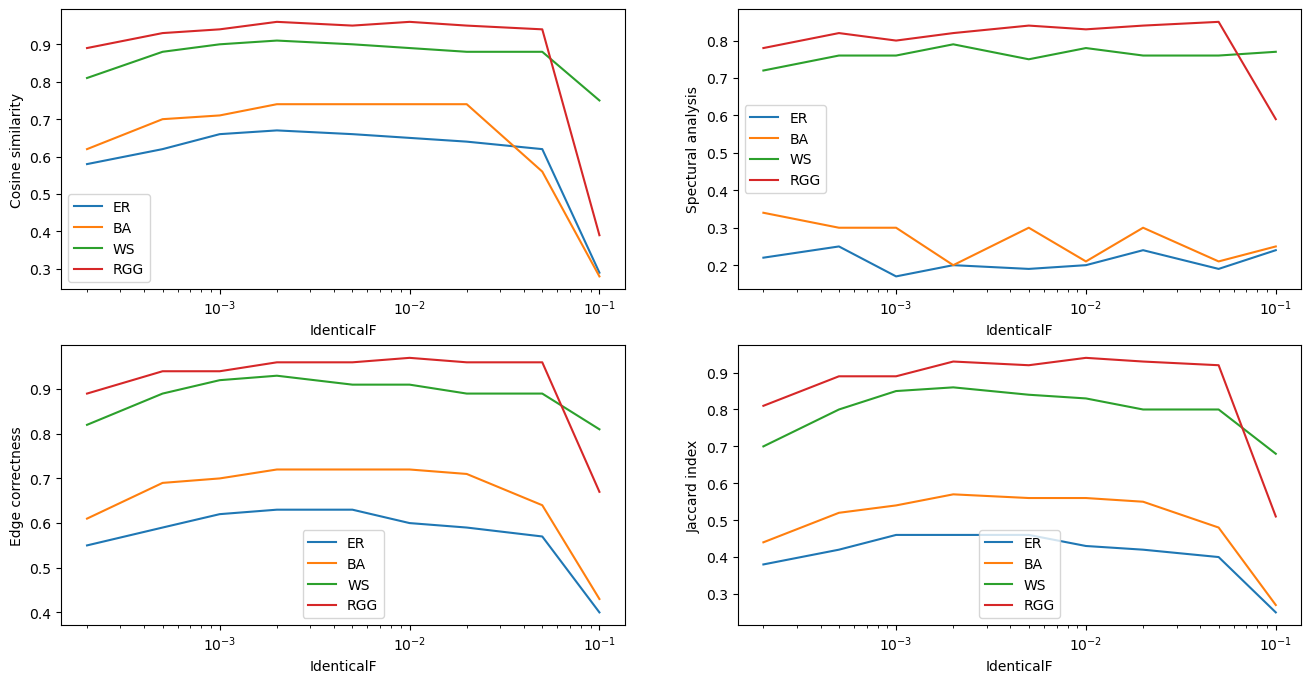

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))

axs[0, 0].plot(identicalfs ,cosinesNp.T)
axs[0, 0].set_ylabel('Cosine similarity')
axs[0, 0].set_xlabel("IdenticalF")
axs[0, 0].set_xscale('log')
axs[0, 0].legend(["ER", "BA", "WS", "RGG"])


axs[0, 1].plot(identicalfs ,spectralsNp.T)
axs[0, 1].set_ylabel('Spectural analysis')
axs[0, 1].set_xlabel("IdenticalF")
axs[0, 1].set_xscale('log')
axs[0, 1].legend(["ER", "BA", "WS", "RGG"])

axs[1, 0].plot(identicalfs ,edgesNp.T)
axs[1, 0].set_ylabel('Edge correctness')
axs[1, 0].set_xlabel("IdenticalF")
axs[1, 0].set_xscale('log')
axs[1, 0].legend(["ER", "BA", "WS", "RGG"])

axs[1, 1].plot(identicalfs ,jaccardsNp.T)
axs[1, 1].set_ylabel('Jaccard index')
axs[1, 1].set_xlabel("IdenticalF")
axs[1, 1].set_xscale('log')
axs[1, 1].legend(["ER", "BA", "WS", "RGG"])



In [39]:

identicalf= 0.01
node= 50
#Performance on different identicalf

for randomGraph in randomGraphs:
    cosinesList= []
    spectralsList= []
    edgesList= []
    jaccardsList= []
    for identicalf in identicalfs:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        for seed in seeds:
            fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{4}_0_8_50_{identicalf*1000}_140000.npz"
            IMatrix= torch.eye(node, device= "cpu")
            npzfile = np.load(fileName)
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosines+= evaluate.cosine_similarity(Aw, PreA)
            spectrals+= evaluate.spectral_analysis(Aw, PreA)
            edges+= evaluate.edge_correctness(Aws, PreAs)
            jaccards+= evaluate.jaccard_index(Aws, PreAs)
        cosines/= len(seeds)
        spectrals/= len(seeds)
        edges/= len(seeds)
        jaccards/= len(seeds)
        cosinesList.append(f"{cosines:.2f}")
        spectralsList.append(f"{spectrals:.2f}")
        edgesList.append(f"{edges:.2f}")
        jaccardsList.append(f"{jaccards:.2f}")
        print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
    #print("\t".join(cosinesList)+"\t"+"\t".join(spectralsList)+"\t"+"\t".join(edgesList)+"\t"+"\t".join(jaccardsList))
    print()


0.74	0.49	0.69	0.53	0.74	0.51	0.69	0.52	0.73	0.48	0.68	0.51	
0.77	0.49	0.73	0.58	0.77	0.49	0.74	0.59	0.76	0.42	0.73	0.57	
0.77	0.64	0.74	0.59	0.77	0.70	0.75	0.60	0.77	0.70	0.74	0.59	
0.94	0.91	0.98	0.95	0.93	0.93	0.97	0.95	0.93	0.90	0.97	0.95	
